# Binary Classification

Source: https://github.com/logictensornetworks/logictensornetworks/blob/master/examples/binary_classification/binary_classification.ipynb

Modified by Erik Mayer:
+ 6/17/2024: To work on Google Colab, added !pip install...

This is a basic example in which we learn to ground unary predicate $A$ that is defined in the space of $[0,1]^2$.

We define the predicate $A$ to apply to points that are close to the middle point $c=(.5,.5)$.In order to get training data, we randomly sample data from the domain. We split the sample data into two separate sets based on their euclidian distance to $c$. We then define two facts for the predicate $A$. For all points the predicate should apply to, we provide them as positive examples and vice versa for all points that the predicate does not apply to.

To add a local copy of the LogicTensorNetworks repository into your Colab environment, use the following command:

In [1]:
!pip install git+https://github.com/logictensornetworks/logictensornetworks

  Cloning https://github.com/logictensornetworks/logictensornetworks to /tmp/pip-req-build-wonyjcdo
  Running command git clone --filter=blob:none --quiet https://github.com/logictensornetworks/logictensornetworks /tmp/pip-req-build-wonyjcdo
  Resolved https://github.com/logictensornetworks/logictensornetworks to commit d62d101f90be8ec029de90cb1db5df01c2c58d72
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ltn: filename=ltn-2.1-py3-none-any.whl size=13029 sha256=efa09371503f66c1d5e3508dfefc06df5dca2e2106e21421fc4c2f5540579507
  Stored in directory: /tmp/pip-ephem-wheel-cache-w8wcekzn/wheels/85/92/5c/138f4ade7bf608ca2b334e77af7af507a4e60bcb33b088f529
Successfully built ltn


In [2]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ltn

plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

Sample random data from $[0,1]^2$. Our groundtruth positive training data for $A$ is close to the center (.5,.5). All other data is considered as negative examples.

[[0.94323265 0.08545707]
 [0.23654894 0.63786807]
 [0.77462662 0.55207451]
 [0.04437354 0.13984533]
 [0.58383077 0.00961061]
 [0.92200324 0.00414483]
 [0.92271552 0.48085187]
 [0.31492727 0.38126252]
 [0.33872974 0.24293339]
 [0.814022   0.63707505]
 [0.15236735 0.11523406]
 [0.29234568 0.89940013]
 [0.91546872 0.60443316]
 [0.37984848 0.86329996]
 [0.23246474 0.58576954]
 [0.7402909  0.06347935]
 [0.45193147 0.15647203]
 [0.02345282 0.25023764]
 [0.79546197 0.24978329]
 [0.93167809 0.94662745]
 [0.26360395 0.27076992]
 [0.47872313 0.84857288]
 [0.56214949 0.50580772]
 [0.62636922 0.24190772]
 [0.66891632 0.27052137]
 [0.47229924 0.62547742]
 [0.10244559 0.38963851]
 [0.45139136 0.80072502]
 [0.33591714 0.52875589]
 [0.81100724 0.91792822]
 [0.2063641  0.03276843]
 [0.60838971 0.82382747]
 [0.54049949 0.92331199]
 [0.83459203 0.17882182]
 [0.3053524  0.74974797]
 [0.25429177 0.17429844]
 [0.97564739 0.18331282]
 [0.95314848 0.13453256]
 [0.06290505 0.2506977 ]
 [0.99692227 0.37022933]


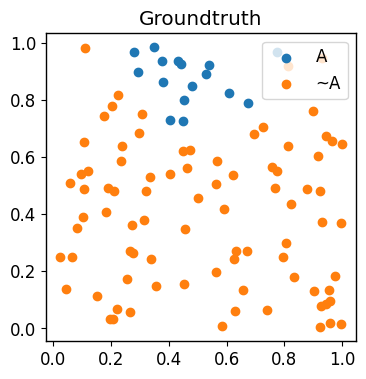

In [17]:
batch_size=64
nr_samples = 100
nr_samples_train = 50 # E.M. - Why no nr_samples_test ?
data = np.random.uniform([0,0],[1,1],(nr_samples,2))
print(data) # Added E.M.
# E.M. Changed from [.5,.5] to [.5,1] below:
labels = np.sum(np.square(data-[.5,1]),axis=1)<.09
print(labels) # Added E.M.
# Below comment doesn't seem to match program
# 400 examples for training; 100 examples for training
ds_train = tf.data.Dataset\
        .from_tensor_slices((data[:nr_samples_train],labels[:nr_samples_train]))\
        .batch(batch_size)
print (ds_train) # Added E. M
ds_test = tf.data.Dataset\
        .from_tensor_slices((data[nr_samples_train:],labels[nr_samples_train:]))\
        .batch(batch_size)
print (ds_test) # Added E. M
plt.figure(figsize=(4,4))
plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')
plt.title("Groundtruth")
plt.legend()
plt.show()


Define the predicate $A$. $A$ has arity 1 (single argument). The dimension of the argument is 2 (since the domain is $[0,1]^2$).

In [18]:
A = ltn.Predicate.MLP([2],hidden_layer_sizes=(16,16))

Import some operators to write the axioms.

In [19]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

Now we add some facts to the knowledgebase. We express that for all points in $\mathrm{data\_A}$, $A$ should be true. For all points in $\mathrm{data\_not\_A}$, $A$ is not true.

In [20]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

@tf.function
def axioms(data, labels):
    x_A = ltn.Variable("x_A",data[labels])
    x_not_A = ltn.Variable("x_not_A",data[tf.logical_not(labels)])
    axioms = [
        Forall(x_A, A(x_A)),
        Forall(x_not_A, Not(A(x_not_A)))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

Initialize all layers and the static graph.

In [21]:
for _data, _labels in ds_test:
    print("Initial sat level %.5f"%axioms(_data, _labels))
    break


Initial sat level 0.46043


Train on the knowledgebase.

In [22]:
mean_metrics = tf.keras.metrics.Mean()

trainable_variables = A.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for epoch in range(2000):
    for _data, _labels in ds_train:
        with tf.GradientTape() as tape:
            loss = 1. - axioms(_data, _labels)
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%100 == 0:
        mean_metrics.reset_states()
        for _data, _labels in ds_test:
            mean_metrics(axioms(_data, _labels))
        print("Epoch %d: Sat Level %.3f"%(epoch, mean_metrics.result() ))
mean_metrics.reset_states()
for _data, _labels in ds_test:
    mean_metrics(axioms(_data, _labels))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, mean_metrics.result() ))

Epoch 0: Sat Level 0.463
Epoch 100: Sat Level 0.609
Epoch 200: Sat Level 0.718
Epoch 300: Sat Level 0.762
Epoch 400: Sat Level 0.763
Epoch 500: Sat Level 0.736
Epoch 600: Sat Level 0.704
Epoch 700: Sat Level 0.678
Epoch 800: Sat Level 0.662
Epoch 900: Sat Level 0.652
Epoch 1000: Sat Level 0.645
Epoch 1100: Sat Level 0.641
Epoch 1200: Sat Level 0.639
Epoch 1300: Sat Level 0.638
Epoch 1400: Sat Level 0.637
Epoch 1500: Sat Level 0.636
Epoch 1600: Sat Level 0.636
Epoch 1700: Sat Level 0.635
Epoch 1800: Sat Level 0.635
Epoch 1900: Sat Level 0.635
Training finished at Epoch 1999 with Sat Level 0.635


The following queries the database on training data and test data. Vizualisation show the extent of generalization.

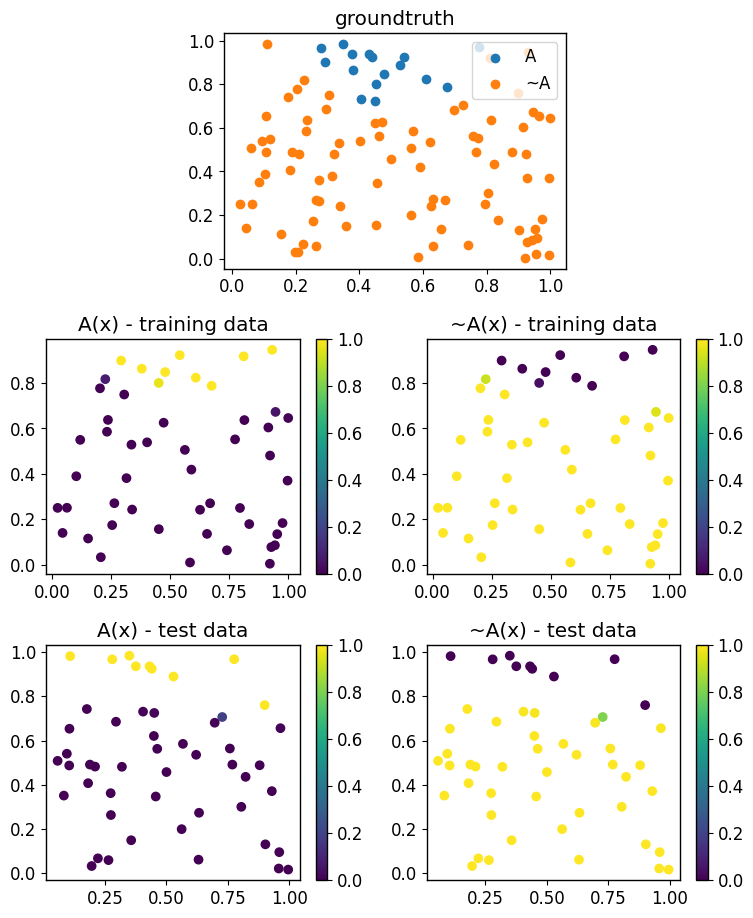

In [23]:
fig = plt.figure(figsize=(9, 11))

plt.subplots_adjust(wspace=0.2,hspace=0.3)
ax = plt.subplot2grid((3,8),(0,2),colspan=4)
ax.set_title("groundtruth")
ax.scatter(data[labels][:,0],data[labels][:,1],label='A')
ax.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')
ax.legend()

# Training data
x = ltn.Variable("x",data[:nr_samples_train])
fig.add_subplot(3, 2, 3)
result=A(x)
plt.title("A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 4)
result=Not(A(x))
plt.title("~A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

# Test data
x = ltn.Variable("x",data[nr_samples_train:])
fig.add_subplot(3, 2, 5)

result=A(x)
plt.title("A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 6)
result=Not(A(x))
plt.title("~A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.tensor.numpy().squeeze())
plt.colorbar()
plt.savefig("ex_binary_testing.pdf")
plt.show()